In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from DLC_for_WBFM.utils.projects.finished_project_data import ProjectData
from sklearn.experimental import enable_iterative_imputer
import napari
import pandas as pd
from sklearn.impute import IterativeImputer
import numpy as np


Bad key "text.kerning_factor" on line 4 in
/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
fname = "/scratch/zimmer/Charles/dlc_stacks/worm3-imputation/project_config.yaml"
project_data = ProjectData.load_final_project_data_from_config(fname)

Project data for directory:
/scratch/zimmer/Charles/dlc_stacks/worm3-imputation 
Found the following raw data files:
red_data: True
green_data: True
============Segmentation===============
raw_segmentation: True
segmentation: True
============Tracklets==================
df_training_tracklets: True
reindexed_masks_training: True
============Traces=====================
red_traces: True
green_traces: True
final_tracks: True
behavior_annotations: True



# Compare dataframes before and after imputation

In [74]:
fname = '/scratch/zimmer/Charles/dlc_stacks/worm3-imputation/3-tracking/postprocessing/combined_3d_tracks_imputed.h5'
imputed_df = pd.read_hdf(fname)

In [75]:
basic_df = project_data.final_tracks

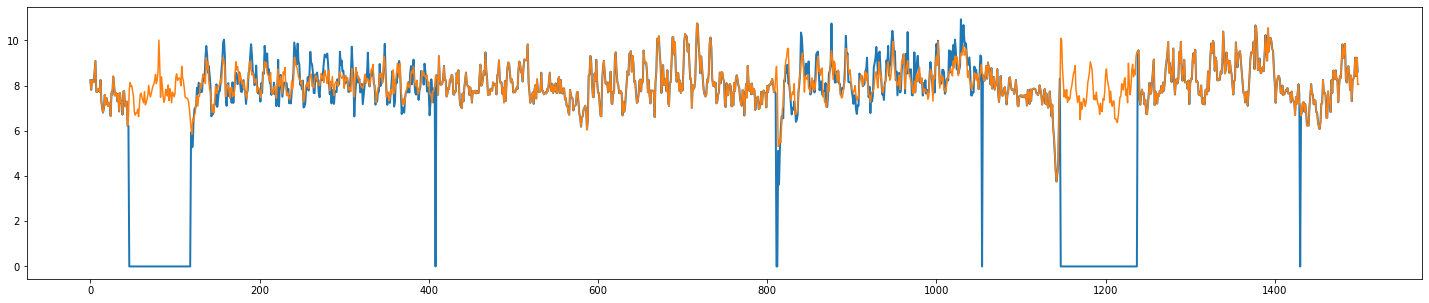

In [76]:
name = 'neuron_003'
coord = 'z'

plt.figure(figsize=(25,5))
basic_df[name][coord].plot(lw=2)
imputed_df[name][coord].plot()


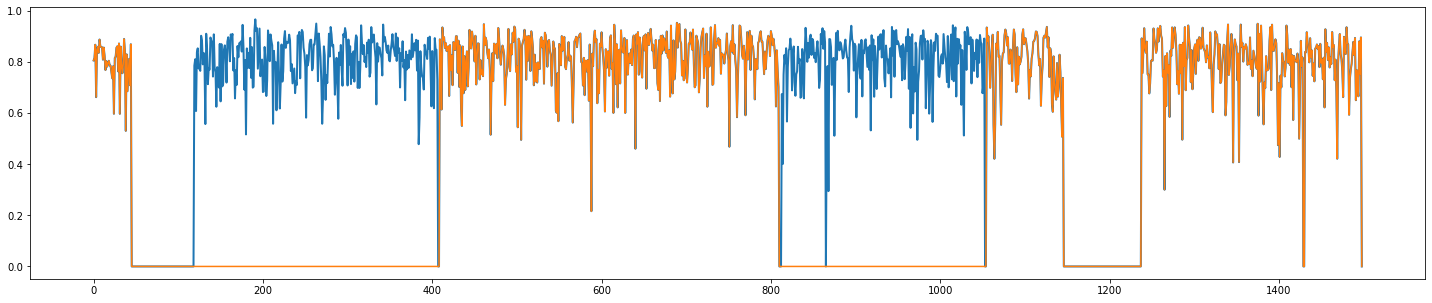

In [77]:
name = 'neuron_003'
coord = 'likelihood'

plt.figure(figsize=(25,5))
basic_df[name][coord].plot(lw=2)
imputed_df[name][coord].plot()

In [88]:
fname = '/scratch/zimmer/Charles/dlc_stacks/worm3-imputation/3-tracking/postprocessing/combined_3d_tracks-1.h5'
imputed_df2 = pd.read_hdf(fname)

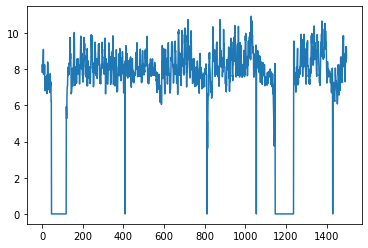

In [89]:
name = 'neuron_003'
coord = 'z'
imputed_df2[name][coord].plot()

# Use imputed coordinates to match to tracklets

In [3]:
from DLC_for_WBFM.utils.postprocessing.combine_tracklets_and_DLC_tracks import _unpack_tracklets_for_combining, calc_dlc_to_tracklet_distances, calc_covering_from_distances, combine_global_and_tracklet_coverings, _save_combined_dataframe
import os
import logging
from tqdm.auto import tqdm
from pathlib import Path
from DLC_for_WBFM.utils.projects.utils_filepaths import pickle_load_binary

In [4]:
project_dir = project_data.project_dir
track_config = project_data.project_config.get_tracking_config()
training_cfg = project_data.project_config.get_training_config()
DEBUG = False

In [26]:
d_max, df_global_tracks, df_tracklets, min_overlap, output_df_fname, \
        keep_only_tracklets_in_final_tracks, global2tracklet, used_indices = _unpack_tracklets_for_combining(
            project_dir, training_cfg, track_config)

In [27]:
d_max = 15.0

In [28]:
# Load different starting point for matches
fname = os.path.join('global2tracklet-2.pickle')
fname = track_config.resolve_relative_path(fname, prepend_subfolder=True)
if Path(fname).exists():
    logging.info(f"Found previous tracklet matches at {fname}")
    global2tracklet = pickle_load_binary(fname)
    used_indices = set()
    [used_indices.update(ind) for ind in global2tracklet.values()]
else:
    logging.info(f"Did not find previous tracklet matches")
    global2tracklet = defaultdict(list)
    used_indices = set()

In [32]:
# Instead of the default, use the imputed tracks as the starting point
fname = os.path.join('postprocessing', 'imputed_3d_tracks-2.h5')
fname = track_config.resolve_relative_path(fname, prepend_subfolder=True)
df_global_tracks = pd.read_hdf(fname)

print(f"{len(used_indices)} / {df_tracklets.shape[1]/4} tracklets used initially")


5307 / 12176.0 tracklets used initially


In [34]:
# Match tracklets to DLC neurons
global_neuron_names = list(df_global_tracks.columns.levels[0])
verbose = 0
logging.info("Calculating distances between tracklets and DLC tracks")
for i, global_name in enumerate(tqdm(global_neuron_names)):
    dist = calc_dlc_to_tracklet_distances(df_global_tracks, df_tracklets, global_name, used_indices,
                                          min_overlap=min_overlap)
    out = calc_covering_from_distances(dist, df_tracklets, used_indices, d_max=d_max, verbose=verbose)
    _, covering_ind, _ = out
    global2tracklet[global_name].extend(covering_ind)
    used_indices.update(covering_ind)
    

# Combine and save
# Rename to be sequential, like the reindexed segmentation
logging.info("Concatenating tracklets")
combined_df, new_tracklet_df = combine_global_and_tracklet_coverings(global2tracklet,
                                                                     df_tracklets,
                                                                     df_global_tracks,
                                                                     keep_only_tracklets_in_final_tracks,
                                                                     verbose=0)

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

  0%|          | 0/12176 [00:00<?, ?it/s]

In [35]:
# %debug

In [36]:
# all_medians = list(map(np.nanmedian, dist))
# np.sort(all_medians)[:3], np.argsort(all_medians)[:3]

In [37]:
# all_tracklet_names = list(df_tracklets.columns.levels[0])
# t_name = all_tracklet_names[2292]
# t = df_tracklets[t_name]
# t.plot()

In [38]:
# all_tracklet_names = list(df_tracklets.columns.levels[0])
# t_name = all_tracklet_names[2292]
# t = df_tracklets[t_name]
# t['z'].plot()
# t['likelihood'].plot()

In [39]:
print(f"{len(used_indices)} / {df_tracklets.shape[1]/4} tracklets used in total")


5539 / 12176.0 tracklets used in total


In [40]:
# Save
from DLC_for_WBFM.utils.projects.utils_project import safe_cd

with safe_cd(project_dir):
    fname = track_config.config['global2tracklet_matches_fname']
    fname = fname[:-7] + "-3.pickle"
    print(fname)
    track_config.pickle_in_local_project(global2tracklet, fname)

output_df_fname = os.path.join('postprocessing', 'combined_3d_tracks-3.h5')
output_df_fname = track_config.resolve_relative_path(output_df_fname, prepend_subfolder=True)

_save_combined_dataframe(DEBUG, combined_df, output_df_fname, project_dir, track_config)

3-tracking/global2tracklet-3.pickle


# Check differences

In [50]:
# Raw positions
fname = os.path.join('postprocessing', 'combined_3d_tracks.h5')
fname = track_config.resolve_relative_path(fname, prepend_subfolder=True)
df = pd.read_hdf(fname)

fname = os.path.join('postprocessing', 'combined_3d_tracks_imputed-1.h5')
fname = track_config.resolve_relative_path(fname, prepend_subfolder=True)
df1 = pd.read_hdf(fname)

fname = os.path.join('postprocessing', 'combined_3d_tracks-3.h5')
fname = track_config.resolve_relative_path(fname, prepend_subfolder=True)
df3 = pd.read_hdf(fname)

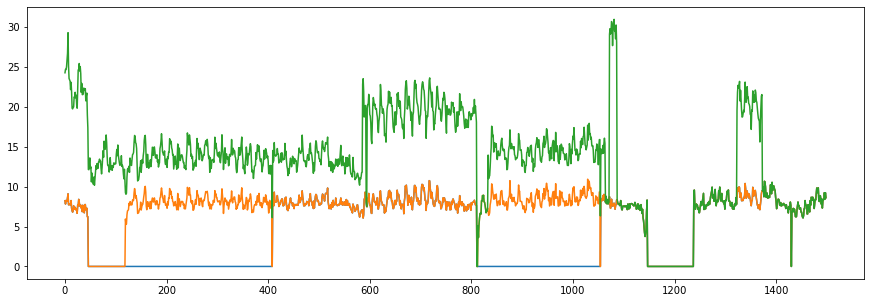

In [58]:
name = 'neuron_003'

plt.figure(figsize=(15,5))
df[name]['z'].plot()
df1[name]['z'].plot()
df3[name]['z'].plot()

In [59]:
# Tracklet matches
fname = os.path.join('global2tracklet.pickle')
fname = track_config.resolve_relative_path(fname, prepend_subfolder=True)
g2t = pickle_load_binary(fname)

fname = os.path.join('global2tracklet-1.pickle')
fname = track_config.resolve_relative_path(fname, prepend_subfolder=True)
g2t_1 = pickle_load_binary(fname)

fname = os.path.join('global2tracklet-2.pickle')
fname = track_config.resolve_relative_path(fname, prepend_subfolder=True)
g2t_2 = pickle_load_binary(fname)

fname = os.path.join('global2tracklet-3.pickle')
fname = track_config.resolve_relative_path(fname, prepend_subfolder=True)
g2t_3 = pickle_load_binary(fname)

In [87]:
from DLC_for_WBFM.utils.projects.utils_project import get_sequential_filename
fname
fname = Path(fname)
base_fname = fname.stem
out_fname = get_sequential_filename(fname.with_name(f"{base_fname}.h5"))

out_fname

Original fname /scratch/zimmer/Charles/dlc_stacks/worm3-imputation/3-tracking/postprocessing/combined_3d_tracks_imputed.h5 exists, so will be suffixed


'combined_3d_tracks_imputed-1.h5'

In [61]:
m0 = g2t[name]
m1 = g2t_1[name]
m2 = g2t_2[name]
m3 = g2t_3[name]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 49

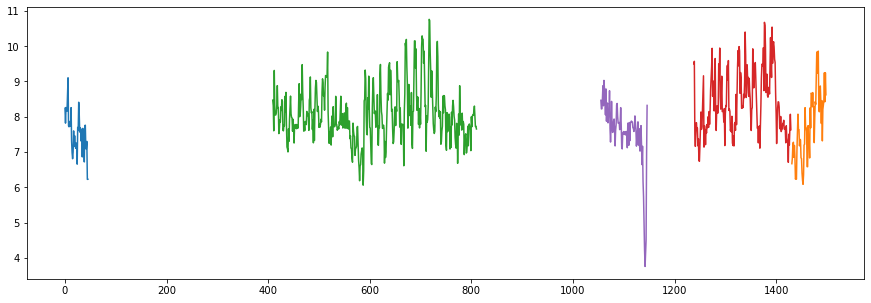

In [68]:
all_tracklet_names = list(df_tracklets.columns.levels[0])
t = df_tracklets.index

for m in [m0, m1, m2, m3]:
    covered_times = []
    plt.figure(figsize=(15,5))
    for i in m:
        tracklet_name = all_tracklet_names[i]
        df_tracklets[tracklet_name]['z'].plot()
        
        is_nan = df_tracklets[tracklet_name]['x'].isnull()
        covered_times.extend(list(t[~is_nan]))
    print(covered_times)
    break

In [78]:
# covered_times.sort()
# covered_times

# Different file types, all using pandas

In [103]:
df = df_tracklets

In [105]:
%%time

fname = 'zzz_tracklets.csv'
df.to_csv(fname)

CPU times: user 1min 15s, sys: 504 ms, total: 1min 15s
Wall time: 1min 15s


In [106]:
%%time
tmp = pd.read_csv(fname);

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/IPython/core/magics/execution.py:1321: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,2

CPU times: user 1min 18s, sys: 2.11 s, total: 1min 20s
Wall time: 1min 20s


In [107]:
%%time

fname = 'zzz_tracklets.h5'
df.to_hdf(fname, key='df_with_missing')

CPU times: user 640 ms, sys: 701 ms, total: 1.34 s
Wall time: 1.34 s


In [108]:
%%time

tmp2 = pd.read_hdf(fname, key='df_with_missing')

CPU times: user 421 ms, sys: 373 ms, total: 794 ms
Wall time: 793 ms


In [109]:
%%time

fname = 'zzz_tracklets.pickle'
df.to_pickle(fname)

CPU times: user 157 ms, sys: 689 ms, total: 846 ms
Wall time: 841 ms


In [110]:
%%time
tmp3 = pd.read_pickle(fname)

CPU times: user 113 ms, sys: 617 ms, total: 730 ms
Wall time: 728 ms


In [116]:
%%time

fname = 'zzz_tracklets_table.h5'
df.to_hdf(fname, key='df_with_missing', format='table')

HDF5ExtError: HDF5 error back trace

  File "H5A.c", line 279, in H5Acreate2
    unable to create attribute
  File "H5Aint.c", line 323, in H5A__create
    unable to create attribute
  File "H5Aint.c", line 277, in H5A__create_common
    unable to create attribute in object header
  File "H5Oattribute.c", line 335, in H5O__attr_create
    unable to create new attribute in header
  File "H5Omessage.c", line 222, in H5O__msg_append_real
    unable to create new message
  File "H5Omessage.c", line 1926, in H5O__msg_alloc
    unable to allocate space for message
  File "H5Oalloc.c", line 1312, in H5O__alloc
    object header message is too large

End of HDF5 error back trace

Can't set attribute 'non_index_axes' in node:
 /df_with_missing (Group) ''.

## Try dask

In [24]:
tracklet_fname = training_cfg.resolve_relative_path('all_tracklets.h5', prepend_subfolder=True)
import dask.dataframe as dd

In [117]:
# %%time

# tmp = pd.read_hdf(tracklet_fname)

In [118]:
df_dask = dd.from_pandas(df)

ValueError: Exactly one of npartitions and chunksize must be specified.

In [27]:
%%time

# tmp = dd.read_hdf(tracklet_fname, key='df_with_missing')

TypeError: 
This HDFStore is not partitionable and can only be use monolithically with
pandas.  In the future when creating HDFStores use the ``format='table'``
option to ensure that your dataset can be parallelized